<a href="https://colab.research.google.com/github/shahparth0007/Google_Collab_Files/blob/main/HRAnalytics_Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **HR Analytics Machine Learning Hackathon from 0 to 100**


---

In this Notebook we will solve HR Analytics Competition from Analytics Vidya!

**Due Date 27th October 2021 Created by: Parth Shah, NUID: 001006181**


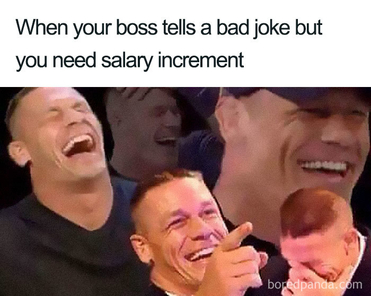


### ***✍🏻 Abstract***

---

Client is a large MNC and they have 9 broad verticals across the organisation. One of the problem your client is facing is around identifying the right people for promotion (only for manager position and below) and prepare them in time. Currently the process, they are following is:

They first identify a set of employees based on recommendations/ past performance
Selected employees go through the separate training and evaluation program for each vertical. These programs are based on the required skill of each vertical
At the end of the program, based on various factors such as training performance, KPI completion (only employees with KPIs completed greater than 60% are considered) etc., employee gets promotion

**The task is to predict whether a potential promotee at checkpoint in the test set will be promoted or not after the evaluation process.**


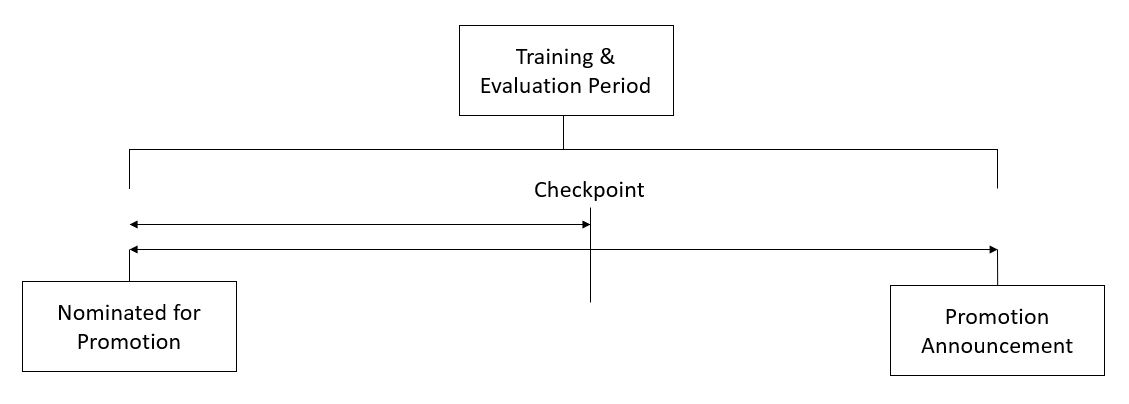


### ***✍🏻 Column Understanding (Logical way)***

---
Before diving into the data lets, lets understand the columns of the data and try to interpret them and make appropraite assumption!The data should support maximum of our assumptions! 



**1)** ***employee_id*** : Employee id of the employee (Should be unique across the data)

**2)** ***Department, Region, Education, Gender***: Demographic Variables of the employee as mentioned there are 9 departments across MNC. We can also assume some nulls present in education

**3)** ***no_of_trainings*** : no of other trainings completed in previous year on soft skills, technical skills etc. This can be an important variable and we can assume that more the no of training more knowldge the employee has for her/his department and more likely to perfrom well.

**GT no_of_trainings ∝ likely to get Promoted**

**4)** ***age*** : Age of an employee can also be a good predictor for y Variable! As older employees have very less positions for promotions which in turn make them less likely to get promoted which is inverse with younger employees!

### ***✍🏻 Importing Libraries***

---



In [ ]:
# Data Preprocessing, Machine Learning and Metrics Libraries 
!pip install shap
import pandas as pd
import numpy as np
import pylab as py
import missingno as msno
import math
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

# Data Visualization
import seaborn as sns #Helps in plotting beautiful graphs and plots
import matplotlib 
import matplotlib.pyplot as plt #Helps in plotting beautiful graphs and plots
import shap

# Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier #Helps in Building Decision Tree Model
import statsmodels.api as sm
from xgboost import XGBClassifier
!pip install catboost
!pip install lightgbm
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
print('*** Libraries loaded ***')


     |████████████████████████████████| 371 kB 4.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for shap: filename=shap-0.40.0-cp37-cp37m-linux_x86_64.whl size=509233 sha256=eef0a9141c1a71f726adcc7ecec42abb5fe991cc889b02f29fc08449a0443a56
  Stored in directory: /root/.cache/pip/wheels/ec/35/84/e304841ac4b910bc95fe9a6e5302eb2507b4333728851dcbfb
Successfully built shap


pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


     |████████████████████████████████| 76.4 MB 28 kB/s 
*** Libraries loaded ***


### ***✍🏻 Importing Data***

---
Importing Train and Validation (Leader Board data) from AV.
Here we will use 2 Datasets in total

**Train** : Train Data

**Validation** : The unseen data.


>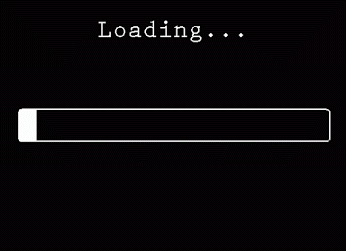




In [ ]:
raw_data_train = pd.read_csv("https://raw.githubusercontent.com/shahparth0007/Datasets/main/Train_HR_Analytics.csv")
raw_data_validation = pd.read_csv("https://raw.githubusercontent.com/shahparth0007/Datasets/main/Test_HR_Analytics.csv")

### ***✍🏻 Assignment Module 1: Data Checking*** 

---

The data has been loaded now lets check the data.
Some of the check which we will do includes:

**1)** *Dublicates in the Data*

**2)** *Missing values in the Data*

**3)** *Garbage Values in the Data*

**4)** *Outliers in the Data*


In [ ]:
print("Shape of Train Data",raw_data_train.shape)
print("Shape of Validation Data",raw_data_validation.shape)

#Validation Data has one less column because that is the Response Column

Shape of Train Data (54808, 14)
Shape of Validation Data (23490, 13)


In [ ]:
raw_data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  KPIs_met >80%         54808 non-null  int64  
 11  awards_won?           54808 non-null  int64  
 12  avg_training_score    54808 non-null  int64  
 13  is_promoted           54808 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.9+ MB


In [ ]:
raw_data_train.nunique()

employee_id             54808
department                  9
region                     34
education                   3
gender                      2
recruitment_channel         3
no_of_trainings            10
age                        41
previous_year_rating        5
length_of_service          35
KPIs_met >80%               2
awards_won?                 2
avg_training_score         61
is_promoted                 2
dtype: int64

In [ ]:
# Change all Categorical variables to object type
for i in ['KPIs_met >80%','awards_won?']:
    raw_data_train[i] = np.where(raw_data_train[i] == 1, "Y", "N")
    raw_data_validation[i] = np.where(raw_data_validation[i] ==1, "Y" , "N")

#### ***📍Dublicates in the Data***

---
Sometimes the data might have dublicate records, which means same row more then once. Usally not a problem as there can be more then 1 employee with exactly same values but still we will remove any dublicate records as we have enough rows to build a model.


In [ ]:
# Removes Data Duplicates while Retaining the First one
def remove_duplicate(data):
    print("Shape of Data before Removing Dublicates:",data.shape)
    data.drop_duplicates(keep="first", inplace=True)
    print("Shape of Data after Removing Dublicates:",data.shape)

    return "Checked Duplicates"

# Removes Duplicates from train data
remove_duplicate(raw_data_train)
remove_duplicate(raw_data_validation)

Shape of Data before Removing Dublicates: (54808, 14)
Shape of Data after Removing Dublicates: (54808, 14)
Shape of Data before Removing Dublicates: (23490, 13)
Shape of Data after Removing Dublicates: (23490, 13)


'Checked Duplicates'

#### ***📍 Missing Values***

---
Missing Values are very commnon in datasets, an data without missing values is a myth. There are many ways to handle a missing value treatment.

**for Continuous Variables:**

Fill it with Mean,Median,0

**for Categorical Variables:**

Fill it with Forward Fill, Backward Fill, "Others"

First lets check what column has missing values and fill in accordingly


In [ ]:
##Lets find missing value columns
###Taken from Stackoverflow : https://stackoverflow.com/questions/26266362/how-to-count-the-nan-values-in-a-column-in-pandas-dataframe 

def missing_dataframe(data):
  missing_list = data.columns[data.isna().any()].tolist()
  missing_count = []
  for i in missing_list:
    missing_count.append(sum(pd.isnull(data[str(i)])))
  d = {'Missing_Column':missing_list,'Missing_Values':missing_count}
  Missing_DF = pd.DataFrame(d)
  Missing_DF["%_Missing"] = (Missing_DF['Missing_Values'] / data.shape[0]) * 100
  Missing_DF
  return Missing_DF

display("Train",missing_dataframe(raw_data_train))
display("Validation",missing_dataframe(raw_data_validation))


'Train'

,Missing_Column,Missing_Values,%_Missing
0,education,2409,4.395344
1,previous_year_rating,4124,7.524449


'Validation'

,Missing_Column,Missing_Values,%_Missing
0,education,1034,4.401873
1,previous_year_rating,1812,7.713921


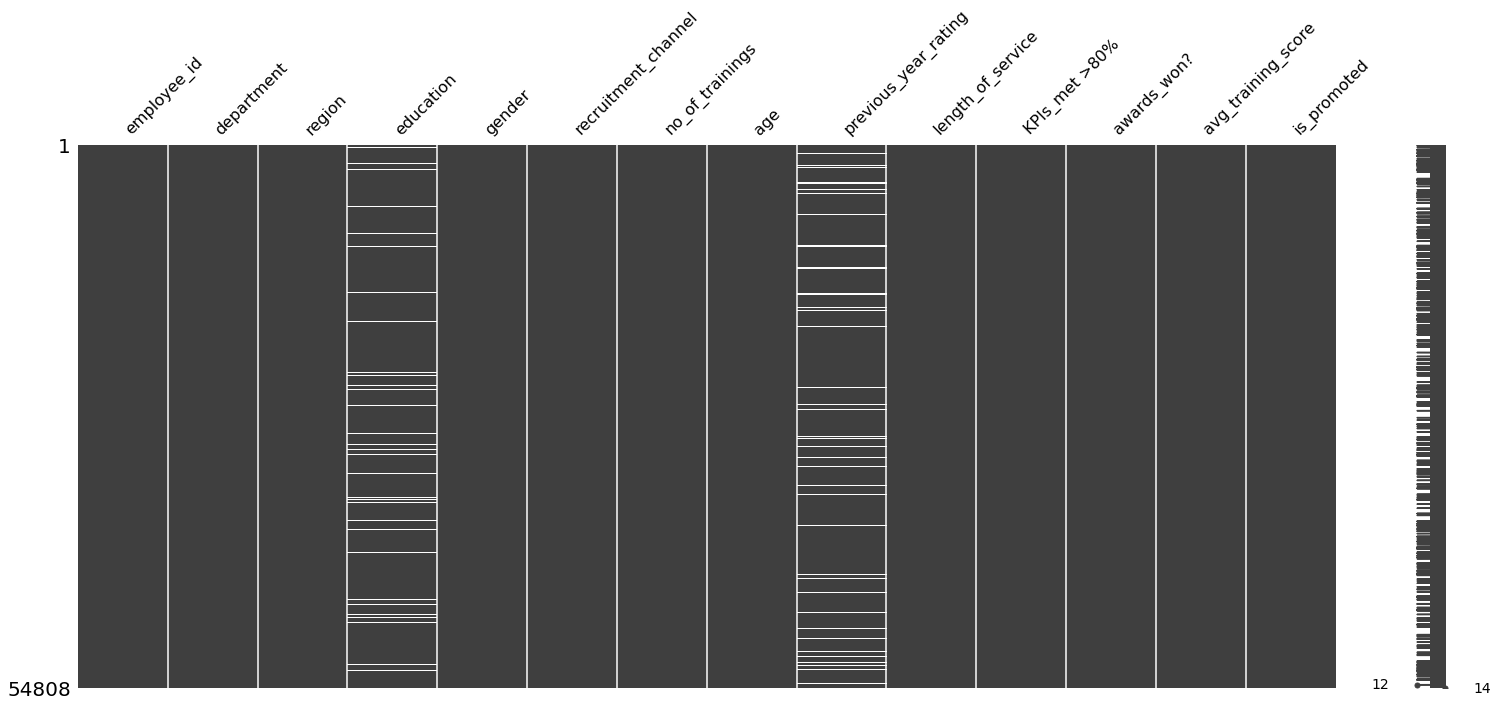

In [ ]:
#visulaizing missing data with a module
msno.matrix(raw_data_train) #https://towardsdatascience.com/using-the-missingno-python-library-to-identify-and-visualise-missing-data-prior-to-machine-learning-34c8c5b5f009

Missing value graphs shows at what point the missing values are there. This is much useful when the dara collected is sequential!

##### ***🔸 Missing Value for "previous_year_rating"***

---

Lets start by imputing missing value in this column.

In [ ]:
#lets first focus on "previous_year_rating"
print("Distinct year of Exp for people with Null previous year rating: ", raw_data_train[raw_data_train['previous_year_rating'].isna()]["length_of_service"].nunique())

Distinct year of Exp for people with Null previous year rating:  1


*Find 1:*  Upon looking closely we can see that people with 1 year exp do not have any previous year rating which is acceptable as they are fresher

*Conclusion of Find 1*: We can impute the missing values with 0 as they all are freshers and do not have rating which mean they should not be promoted

In [ ]:
print("Total Freshers with 1 year exp promoted:",raw_data_train[raw_data_train['previous_year_rating'].isna()]["is_promoted"].sum())

Total Freshers with 1 year exp promoted: 339


*Find 2:* If we go by conclusion of find 1 then we will imputing 0 for previous year rating and 339 people are promoted from them! Which is weird right! I mean which company will promote people with 0 rating duh...

*Conclusion of find 2:* So we will not be imputing 0 for NA. 

In [ ]:
def previous_year_rating_ratio(data):
  if 'is_promoted' in data.columns:
    previous_year_rating_ratio = data[['length_of_service','is_promoted']].groupby(['length_of_service']).sum()
    previous_year_rating_ratio['Total'] = data[['employee_id','length_of_service']].groupby(['length_of_service']).count()
    previous_year_rating_ratio['Avg_Rating'] =  data[['length_of_service','previous_year_rating']].groupby(['length_of_service']).mean()
    return previous_year_rating_ratio
  else:
    previous_year_rating_ratio = data[['employee_id','length_of_service']].groupby(['length_of_service']).count()
    previous_year_rating_ratio['Avg_Rating'] =  data[['length_of_service','previous_year_rating']].groupby(['length_of_service']).mean()
    return previous_year_rating_ratio

raw_data_rating_ratio = previous_year_rating_ratio(raw_data_train)
raw_data_validation_ratio = previous_year_rating_ratio(raw_data_validation)

In [ ]:
raw_data_rating_ratio.iloc[0]['Avg_Rating']

3.2624113475177303

***Find 3:*** We can there are some employees with 1 year experience who have been promoted and also have some ratings. 

***Conclusion from find 3:*** We can taking the mean of that group of people and fill the missing values of this column. Bingo.

In [ ]:
raw_data_train["previous_year_rating"] = raw_data_train["previous_year_rating"].replace(np.nan,math.floor(raw_data_rating_ratio.iloc[0]['Avg_Rating']))
raw_data_validation["previous_year_rating"] = raw_data_validation["previous_year_rating"].replace(np.nan,math.floor(raw_data_validation_ratio.iloc[0]['Avg_Rating']))

##### ***🔸 Missing Value for "Education"***


In [ ]:
raw_data_train["education"] = raw_data_train["education"].replace(np.nan,"Not_Available")
raw_data_validation["education"] = raw_data_validation["education"].replace(np.nan,"Not_Available")

#### ***📍Garbage Value Checking***

---

Not always the values in the columns are meaningfull, there might be some values which does not fit the column description. We should check that and remove them. sus....

In [ ]:
for i in raw_data_train.columns.to_list():
  print("Column Name:",i,"Unique Values",raw_data_train[i].unique())

Column Name: employee_id Unique Values [65438 65141  7513 ... 13918 13614 51526]
Column Name: department Unique Values ['Sales & Marketing' 'Operations' 'Technology' 'Analytics' 'R&D'
 'Procurement' 'Finance' 'HR' 'Legal']
Column Name: region Unique Values ['region_7' 'region_22' 'region_19' 'region_23' 'region_26' 'region_2'
 'region_20' 'region_34' 'region_1' 'region_4' 'region_29' 'region_31'
 'region_15' 'region_14' 'region_11' 'region_5' 'region_28' 'region_17'
 'region_13' 'region_16' 'region_25' 'region_10' 'region_27' 'region_30'
 'region_12' 'region_21' 'region_8' 'region_32' 'region_6' 'region_33'
 'region_24' 'region_3' 'region_9' 'region_18']
Column Name: education Unique Values ["Master's & above" "Bachelor's" 'Not_Available' 'Below Secondary']
Column Name: gender Unique Values ['f' 'm']
Column Name: recruitment_channel Unique Values ['sourcing' 'other' 'referred']
Column Name: no_of_trainings Unique Values [ 1  2  3  4  7  5  6  8 10  9]
Column Name: age Unique Values [35

#### ***📍 Outlier***

---
The data which is collected at companies will have outliers.

 Outliers are the data points which do not fall under normal range of that Column.

 We should do an Outlier treatment before building our model so that the model does not deviate from the actual data Points

We will be Using IQR (Inter quatile range) Outlier treatment for this data

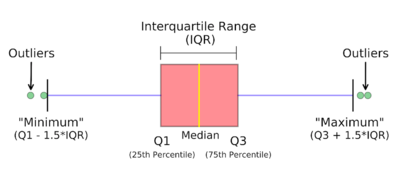



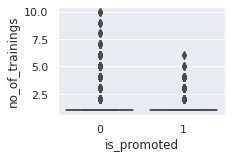

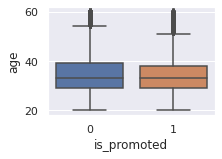

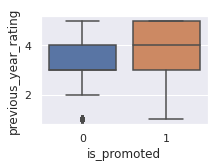

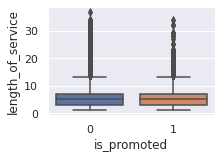

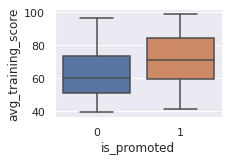

In [ ]:
numerics =['int16','int32','int64','float16','float32','float64']
train_numeric =raw_data_train.select_dtypes(include=numerics)
train_numeric = train_numeric.drop(['is_promoted','employee_id'], axis = 1)
sns.set(rc = {'figure.figsize':(3,2)})
for i, col in enumerate(train_numeric.columns.to_list()):
    plt.figure(i)
    sns.boxplot(raw_data_train['is_promoted'], y= col, data=raw_data_train)

One of the things which is very clear from the box plots is variable "previous_year_rating" has a clear difference in people who are getting promoted and people who are not! More the rating higher chances of getting promoted

In [ ]:
###outlier treatment
numerics =['int16','int32','int64','float16','float32','float64']
train_numeric =raw_data_train.select_dtypes(include=numerics)
vars_tobe_treated =list(train_numeric.columns)
vars_tobe_treated.remove('employee_id')
for cols in vars_tobe_treated:
    Q1 =raw_data_train[cols].quantile(0.25)
    Q3=raw_data_train[cols].quantile(0.75)
    if(Q1 == Q3):
        raw_data_train[cols] =raw_data_train[cols]
    else:
        print('Outlier Treatment happening on: '+ cols)
        IQR= Q3-Q1
        Upper_Limit = Q3+1.5*IQR
        Lower_Limit = Q1-1.5*IQR

        #Doing outlier on raw data
        raw_data_train[cols]=np.where(raw_data_train[cols] > Upper_Limit ,Upper_Limit,raw_data_train[cols])
        raw_data_train[cols]=np.where(raw_data_train[cols] < Lower_Limit ,Lower_Limit,raw_data_train[cols])

        #Doing outlier on Validation
        raw_data_validation[cols]=np.where(raw_data_validation[cols] > Upper_Limit ,Upper_Limit,raw_data_validation[cols])
        raw_data_validation[cols]=np.where(raw_data_validation[cols] < Lower_Limit ,Lower_Limit,raw_data_validation[cols])

print("Outlier_Treatment_Done");

Outlier Treatment happening on: age
Outlier Treatment happening on: previous_year_rating
Outlier Treatment happening on: length_of_service
Outlier Treatment happening on: avg_training_score
Outlier_Treatment_Done


### ***✍🏻 Assignment module 2: Feature Selection and Engineering***

---



For feature selection lets do an correlation matrix first and look if we can delete any of the features which are highly correlated

In [ ]:
raw_data_train_cust_id = raw_data_train['employee_id']
raw_data_validation_cust_id = raw_data_validation['employee_id']
raw_data_train_response = raw_data_train['is_promoted']
raw_data_train_FE = raw_data_train.drop(['employee_id','is_promoted'],axis = 1)

#### ***📍Corellation Matrix***

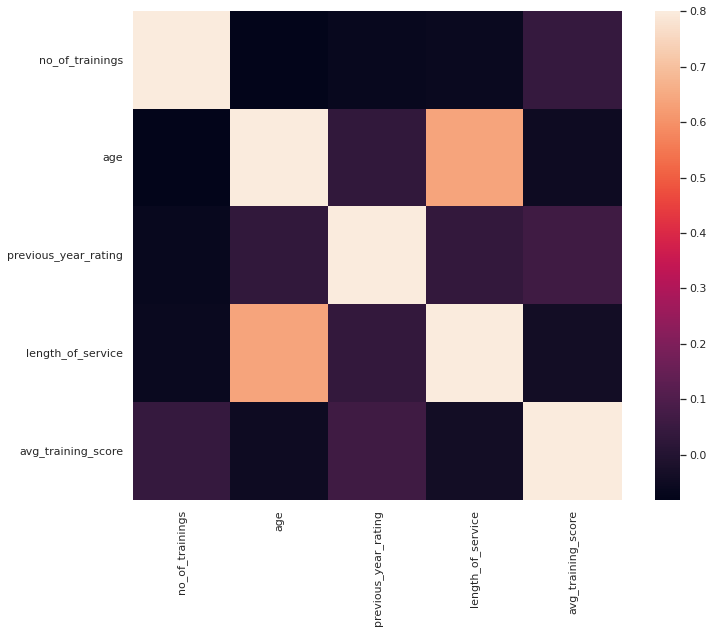

In [ ]:
#correlation matrix
corrmat = raw_data_train_FE.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

In [ ]:
corrmat

,no_of_trainings,age,previous_year_rating,length_of_service,avg_training_score
no_of_trainings,1.000000,-0.082247,-0.062709,-0.059035,0.042517
age,-0.082247,1.000000,0.033864,0.640451,-0.049246
previous_year_rating,-0.062709,0.033864,1.000000,0.036243,0.065820
length_of_service,-0.059035,0.640451,0.036243,1.000000,-0.040358
avg_training_score,0.042517,-0.049246,0.065820,-0.040358,1.000000


**Insigths:** Looking at the correlation matrix first thing which is very clear that there is not much of negtaive corelation in the data.

Secondly we can see that the highest corelation is between length_of_service and age of 0.64 but that can be included in the model as it is not much high to ignore it completely.

#### ***📍CountPlots***

In [ ]:
#Code credits : https://www.kaggle.com/mustafacicek/hr-analytics-analyticsvidhya-8th-place-0-5329-f1

def count_percentage(df, col, hue):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 6))
    order = sorted(df[col].unique())
    palette = ["#0EB8F1", "#F1480F"]
    
    sns.countplot(col, data = df, hue = hue, ax = ax1, order = order, palette = palette)
    ax1.set_title("Counts For Feature:\n" + col)

    df_temp = df.groupby(col)[hue].value_counts(normalize = True).\
    rename("percentage").\
    reset_index()
    
    fig = sns.barplot(x = col, y = "percentage", hue = hue, data = df_temp, ax = ax2, order = order, palette = palette)
    fig.set_ylim(0,1)
    
    fontsize = 14 if len(order) <= 10 else 8
    for p in fig.patches:
        
        txt = "{:.1f}".format(p.get_height() * 100) + "%"
        txt_x = p.get_x() 
        txt_y = p.get_height()
        fig.text(txt_x + 0.125, txt_y + 0.02,txt, fontsize = fontsize)

    ax2.set_title("Percentages For Feature: \n" + col)
    plt.setp(ax1.get_xticklabels(), rotation=70, horizontalalignment='right')
    plt.setp(ax2.get_xticklabels(), rotation=70, horizontalalignment='right')
    
    for ax in [ax1, ax2]:
        ax.set_facecolor("#C7D3D4FF")
        ax.grid(linewidth = 0.25)

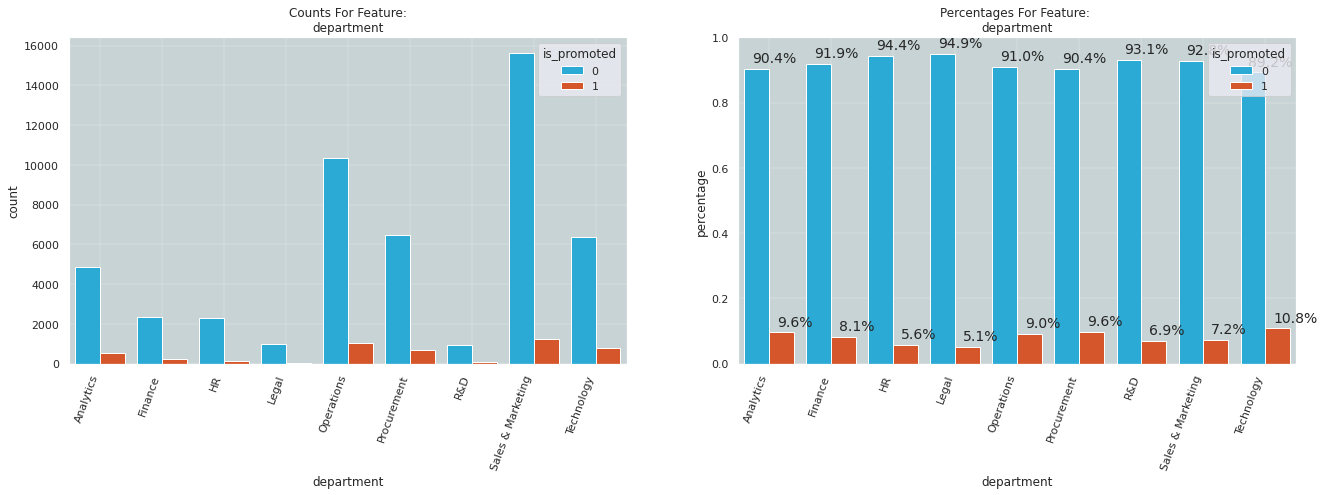

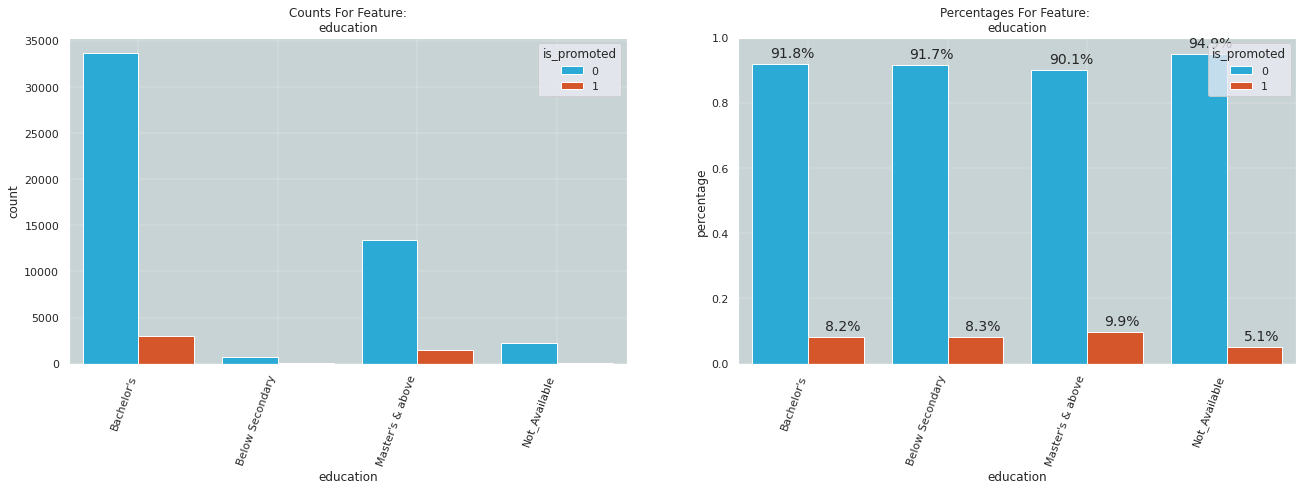

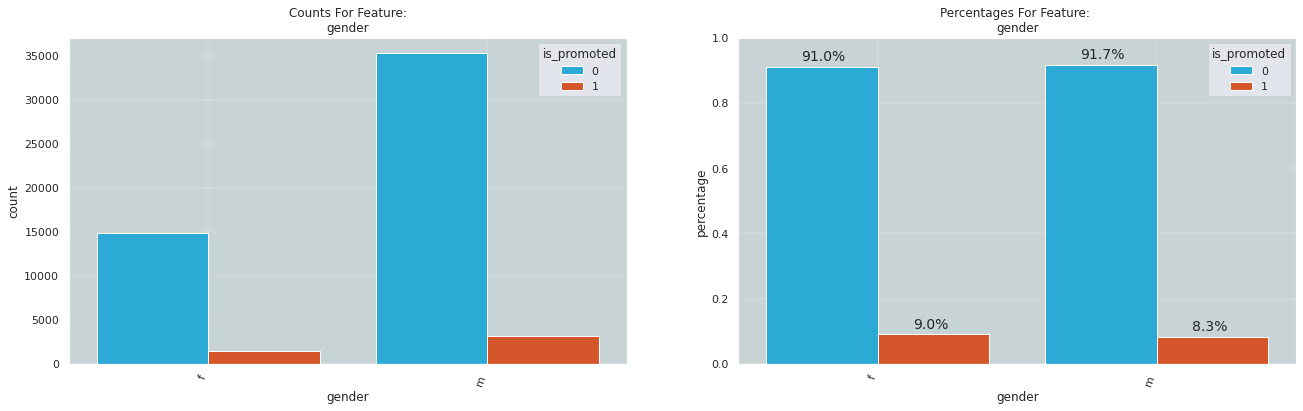

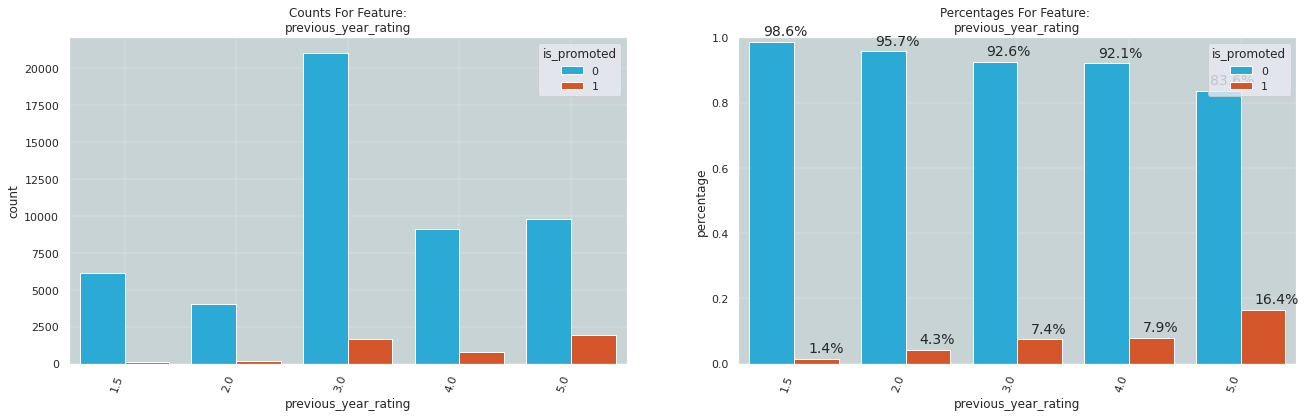

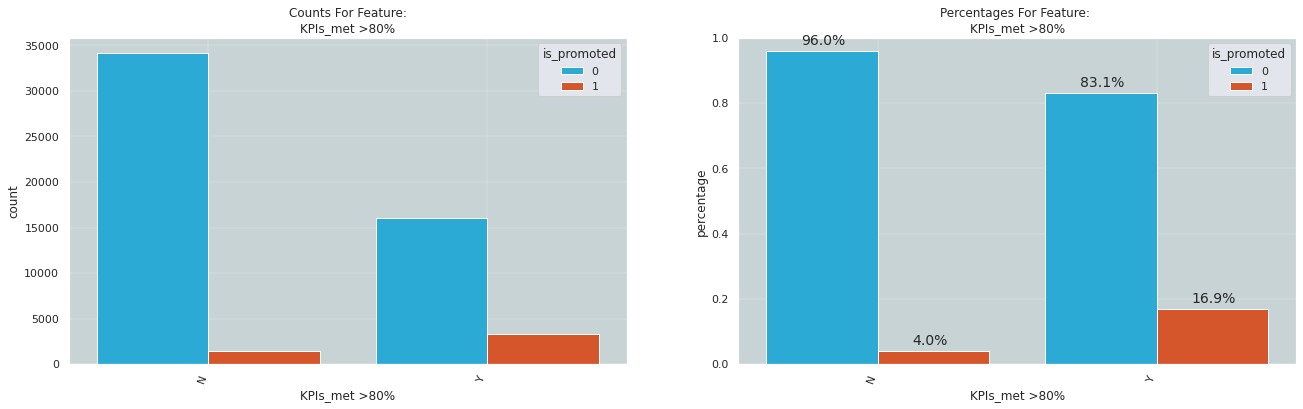

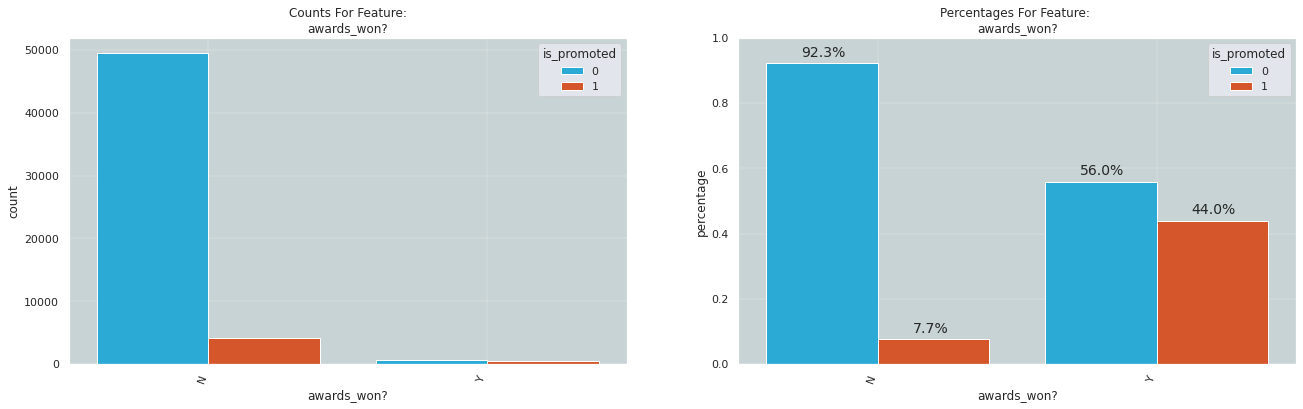

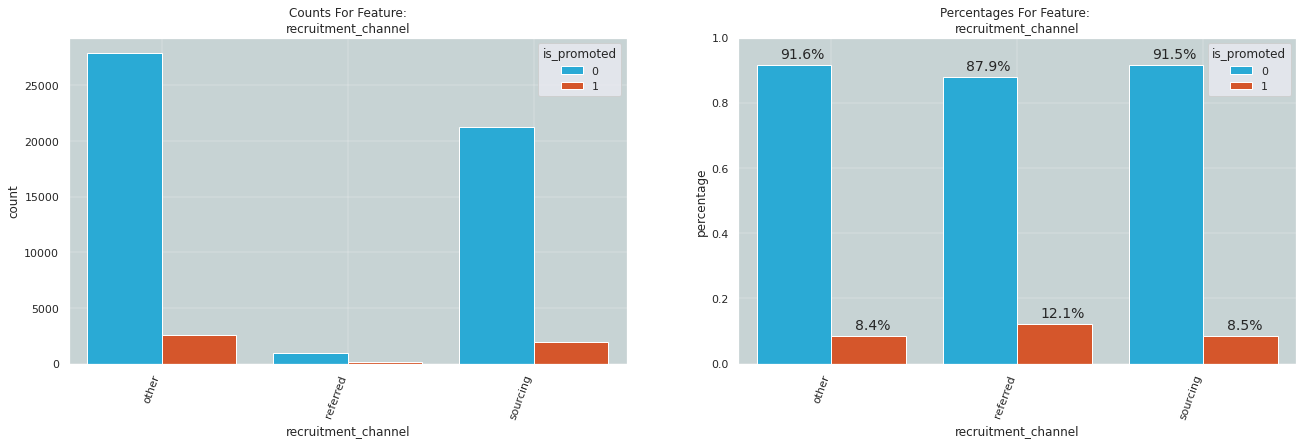

In [ ]:
CAT_LIST = ["department","education","gender","previous_year_rating","KPIs_met >80%","awards_won?",'recruitment_channel']
for i in CAT_LIST:
  count_percentage(raw_data_train, i, "is_promoted")

**Insights:**

Here we have plotted Bar Graphs or also called as count plots. They count the no of categories in the data and thne decide the height of the bar accordingly. Here we have also plotted % graphs to get acrually picture

1.   Wining awards definelty has an impact on getting promoted
2.   A good observation which we can see is that female have a higher % of promotions then men! Period. World is changing



#### ***📍Histograms***

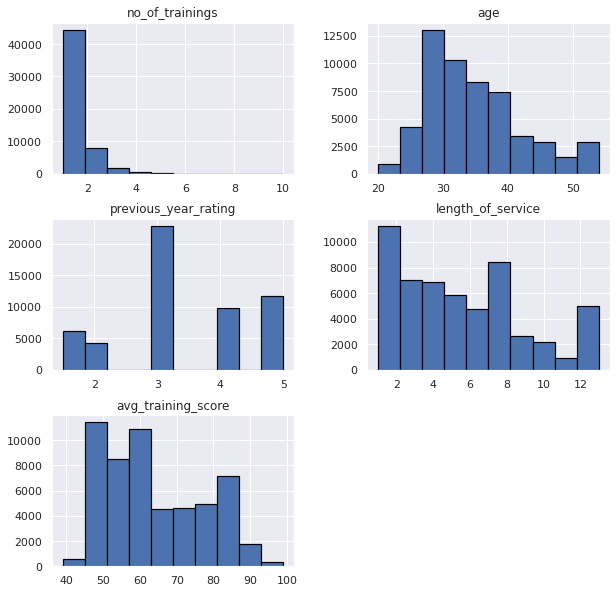

In [ ]:
raw_data_train_FE.hist(edgecolor='black', linewidth=1.2, figsize=(10, 10));

In [ ]:
raw_data_train.dtypes

employee_id               int64
department               object
region                   object
education                object
gender                   object
recruitment_channel      object
no_of_trainings           int64
age                     float64
previous_year_rating    float64
length_of_service       float64
KPIs_met >80%            object
awards_won?              object
avg_training_score      float64
is_promoted               int64
dtype: object

#### ***📍Feature Engineering***

##### ***🔸 Extra Feature Creation***

---
We can Bin the Continuos Variables such as Age to identify the pattern and to tell the model which age groups are similar in nature 


In [ ]:
def age_conditions_function(data):

  conditions = [
      (data['age'] >= 19) & (data['age'] < 25),
      (data['age'] >= 25) & (data['age'] < 30),
      (data['age'] >= 30) & (data['age'] < 40),
      (data['age'] >= 40),
      data['age'].isna()
      ]
  return conditions

def eduaction_conditions_function(data):

  conditions = [
      (data['education'] >= "Master's & above")
      (data['age'] >= 25)
      (data['age'] >= 30)
      (data['age'] >= 40),
      data['age'].isna()
      ]
  return conditions


values = ['19TO24', '25TO30', '30TO40','GT40','Not_Available']
raw_data_train['age_bands'] = np.select(conditions_function(raw_data_train), values)
raw_data_validation['age_bands'] = np.select(conditions_function(raw_data_validation), values)

display(raw_data_train[['age_bands','age','is_promoted']].groupby(['age_bands','is_promoted']).count())


raw_data_train

age
age_bands is_promoted       
19TO24    0             1584
          1              131
25TO30    0            11643
          1             1095
30TO40    0            25474
          1             2556
GT40      0            11439
          1              886

In [ ]:
raw_data_train['education'].unique()

array(["Master's & above", "Bachelor's", 'Not_Available',
       'Below Secondary'], dtype=object)

##### ***🔸 Dummy Variable Creation***

In [ ]:
###creating dummies for model building#####
cols_to_keep_train = raw_data_train.columns.tolist()
cols_to_keep_validation = raw_data_validation.columns.tolist()
cols_to_keep_train.remove('is_promoted')
cols_to_keep_train.remove('employee_id')
cols_to_keep_validation.remove('employee_id')
def getFeatures(df , run_id, tuple_cols_toKeep):
    if(tuple_cols_toKeep is None):
        features = df
    else:
      features = pd.DataFrame(df, columns = tuple_cols_toKeep)
    features = pd.get_dummies(features,drop_first=True)
    return(features)
####calling the dummies function####
features_final_train = getFeatures(raw_data_train,'1020',cols_to_keep_train)
features_final_validation = getFeatures(raw_data_validation,'1020',cols_to_keep_validation)
print("The Shape of Dummy Variables are:",features_final_train.shape)
print("The Shape of Dummy Variables are:",features_final_validation.shape)

The Shape of Dummy Variables are: (54808, 57)
The Shape of Dummy Variables are: (23490, 57)


##### ***🔸 Scaling Values***

In [ ]:
def data_scaling( scaling_strategy , scaling_data , scaling_columns ):
    if    scaling_strategy =="RobustScaler" :
        scaling_data[scaling_columns] = RobustScaler().fit_transform(scaling_data[scaling_columns])
    elif  scaling_strategy =="StandardScaler" :
        scaling_data[scaling_columns] = StandardScaler().fit_transform(scaling_data[scaling_columns])
    elif  scaling_strategy =="MinMaxScaler" :
        scaling_data[scaling_columns] = MinMaxScaler().fit_transform(scaling_data[scaling_columns])
    elif  scaling_strategy =="MaxAbsScaler" :
        scaling_data[scaling_columns] = MaxAbsScaler().fit_transform(scaling_data[scaling_columns])
    else :  # If any other scaling send by mistake still perform Robust Scalar
        scaling_data[scaling_columns] = RobustScaler().fit_transform(scaling_data[scaling_columns])
    return scaling_data
# RobustScaler is better in handling Outliers :
scaling_strategy = ["RobustScaler", "StandardScaler","MinMaxScaler","MaxAbsScaler"]
X_train_scale = data_scaling( scaling_strategy[0] , features_final_train , features_final_train.columns )
X_Validation_scale = data_scaling( scaling_strategy[0] , features_final_validation , features_final_validation.columns )

In [ ]:
X_Validation_scale.head()

,no_of_trainings,age,previous_year_rating,length_of_service,avg_training_score,department_Finance,department_HR,department_Legal,department_Operations,department_Procurement,department_R&D,department_Sales & Marketing,department_Technology,region_region_10,region_region_11,region_region_12,region_region_13,region_region_14,region_region_15,region_region_16,region_region_17,region_region_18,region_region_19,region_region_2,region_region_20,region_region_21,region_region_22,region_region_23,region_region_24,region_region_25,region_region_26,region_region_27,region_region_28,region_region_29,region_region_3,region_region_30,region_region_31,region_region_32,region_region_33,region_region_34,region_region_4,region_region_5,region_region_6,region_region_7,region_region_8,region_region_9,education_Below Secondary,education_Master's & above,education_Not_Available,gender_m,recruitment_channel_referred,recruitment_channel_sourcing,KPIs_met >80%_Y,awards_won?_Y,age_bands_25TO30,age_bands_30TO40,age_bands_GT40
0,0.0,-0.9,0.0,-1.00,0.68,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,-1.0,0.0
1,0.0,-0.2,0.0,0.00,-0.36,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,-0.2,-1.5,-0.25,-0.52,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.0,-0.2,-1.0,1.00,0.20,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,-0.3,1.0,0.50,0.04,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
print("Final TRAIN Dataset has:",X_train_scale.shape[0],"rows and",X_train_scale.shape[1],"columns")
print("Total TRAIN Employees:",raw_data_train_cust_id.shape[0])
print("Total TRAIN Response:",raw_data_train_response.shape[0])

print("Final VALIDATION Dataset has:",X_Validation_scale.shape[0],"rows and",X_Validation_scale.shape[1],"columns")
print("Total VALIDATION Employees:",raw_data_validation_cust_id.shape[0])

Final TRAIN Dataset has: 54808 rows and 57 columns
Total TRAIN Employees: 54808
Total TRAIN Response: 54808
Final VALIDATION Dataset has: 23490 rows and 57 columns
Total VALIDATION Employees: 23490


In [ ]:
X_train_scale.to_csv('Train_Data.csv',index = False)
raw_data_train_response.to_csv('Train_Response.csv',index = False)

### ***✍🏻 Assignment Module 3: Multiple Optimized Models***

#### ***📍Baseline Models***

In [ ]:
# Baseline Model Without Hyperparameters :
# Boosting Algorithms 
Classifiers = {'Logisticregression' : LogisticRegression(),
               'XGBoost' : XGBClassifier(),
               'CatBoost' : CatBoostClassifier(silent=True),
               'LightGBM' : LGBMClassifier(),
               'DecisionTree' : DecisionTreeClassifier()
 }

In [ ]:
voting_model = VotingClassifier(estimators=[
('Logistic_Best', list(Classifiers.values())[0]),
('XGBoost_Best', list(Classifiers.values())[1]),
('CatBoost_Best', list(Classifiers.values())[2]),
('LightGBM_Best', list(Classifiers.values())[3]),
('Decision_Tree_Best', list(Classifiers.values())[4])
],
voting='soft',weights=[5,5,5.9,5.3,0])
voting_model.fit(X_train_scale,raw_data_train_response)


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


VotingClassifier(estimators=[('Logistic_Best',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('XGBoost_Best',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsa...
                              DecisionTreeClassifier(ccp_alpha=0.0,
                                  

In [ ]:
# calculate AUC for Train
#predictions_of_voting_prob = voting_model.predict_proba(X_train_scale)[::,1]
results = {}
predictions_of_voting_class = voting_model.predict(X_train_scale)
predictions_of_voting_class_validation = voting_model.predict(X_Validation_scale)

#print('Train AUC for Voting Classifier: %.3f' % roc_auc_score(raw_data_train_response, predictions_of_voting_prob))
f1_score1 = f1_score(raw_data_train_response, predictions_of_voting_class, average='macro')
print('Train F1 for Voting Classifier: %.3f' % f1_score1)
results['VotingClassifier'] = f1_score1

Train F1 for Voting Classifier: 0.743


In [ ]:
a = list(Classifiers.values())
for i in range(len(a)):
  a[i].fit(X_train_scale,raw_data_train_response)
  predictions_of_voting_prob = a[i].predict_proba(X_train_scale)[::,1]
  predictions_of_voting_class = a[i].predict(X_train_scale)
  print(list(Classifiers.keys())[i],' Train AUC: %.3f'% roc_auc_score(raw_data_train_response, predictions_of_voting_prob))
  print(list(Classifiers.keys())[i],' Train F1 : %.3f' % f1_score(raw_data_train_response, predictions_of_voting_class, average='macro'))
  results[list(Classifiers.keys())[i]] = f1_score(raw_data_train_response, predictions_of_voting_class, average='macro')


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Logisticregression  Train AUC: 0.877
Logisticregression  Train F1 : 0.672
XGBoost  Train AUC: 0.908
XGBoost  Train F1 : 0.696
CatBoost  Train AUC: 0.957
CatBoost  Train F1 : 0.770
LightGBM  Train AUC: 0.941
LightGBM  Train F1 : 0.747
DecisionTree  Train AUC: 1.000
DecisionTree  Train F1 : 0.999


#### ***📍Hyperparameter Models***


---
After having basic models we will tune some parameters inside the models and try to test our validation set on that.


Grid Search

In [ ]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import StratifiedKFold
# xgb_model = XGBClassifier()
# parameters = {'objective':['binary:logistic'],
#               'learning_rate': [0.05,0.01,0.001], #so called `eta` value
#               'max_depth': [6,5,4],
#               'min_child_weight': [11,10],
#               'subsample': [0.8],
#               'colsample_bytree': [0.7],
#               'n_estimators': [1000], #number of trees, change it to 1000 for better results
#               'seed': [1337]}
# clf = GridSearchCV(xgb_model, parameters, n_jobs=5, 
#                    scoring='f1',
#                    verbose=2, refit=True)

In [ ]:
# clf.fit(X_train_scale,raw_data_train_response)

In [ ]:
# clf.best_score_

##### ***🔸 LightGBM Hyperparameter Model***

In [ ]:
LGBM_model = LGBMClassifier(n_estimators=10000, learning_rate=0.005, n_jobs = -1, random_state = 42, 
                         colsample_bytree = 0.3994433425727357, max_depth = 5, min_child_samples = 100,
                         num_leaves = 70, scale_pos_weight = 2.743189307803528, 
                         subsample = 0.9730690656599836, min_split_gain = 0.4990782438045411, 
                         reg_alpha = 4.231800280468554, reg_lambda = 0.276033039672689)

In [ ]:
LGBM_model.fit(X_train_scale,raw_data_train_response)
b = LGBM_model.predict(X_train_scale) 
results['LightGBM_Hyperparameter'] = f1_score(raw_data_train_response, b, average='macro')    

In [ ]:
results_dataframe = pd.DataFrame(list(results.items()))
display(results_dataframe)

,0,1
0,VotingClassifier,0.743404
1,Logisticregression,0.671978
2,XGBoost,0.695652
3,CatBoost,0.770317
4,LightGBM,0.747212
5,DecisionTree,0.999179
6,LightGBM_Hyperparameter,0.753666


### ***✍🏻Assignment Module 4: Interpretebility***

In [ ]:
my_model = RandomForestClassifier(random_state=0).fit(X_train_scale,raw_data_train_response)
explainer = shap.TreeExplainer(my_model)


In [ ]:
explainer = shap.TreeExplainer(LGBM_model)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


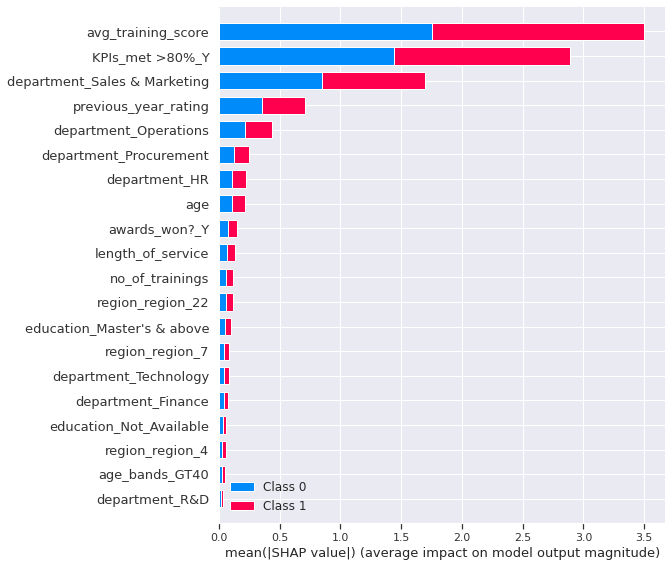

In [ ]:
shap_values = explainer.shap_values(X=X_train_scale.head(800))
shap.summary_plot(shap_values, X_train_scale)

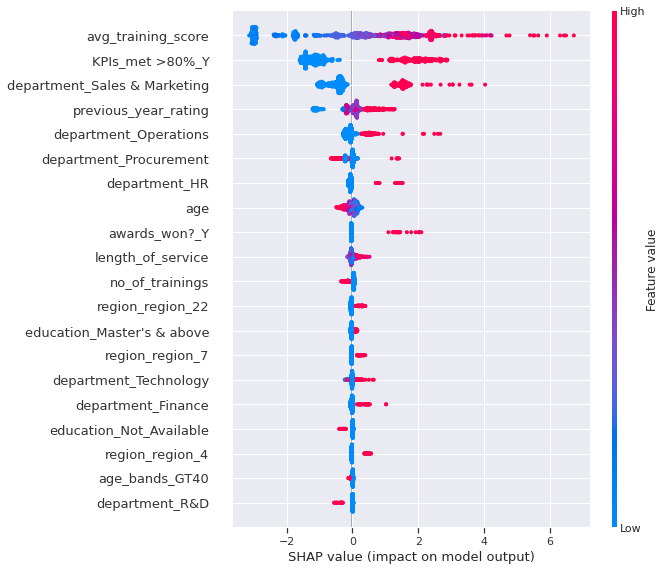

In [ ]:
shap.summary_plot(shap_values[1], X_train_scale.head(800))

### ***✍🏻Assignment Module 5: Competition Score***

In [ ]:
# To make validation csv

# Round off the Probability Results :
Result_Promoted = pd.DataFrame({'employee_id': raw_data_validation_cust_id, 'is_promoted' : predictions_of_voting_class_validation})  
# Round off the Probability Results :
Result_Promoted = pd.DataFrame({'employee_id': raw_data_validation_cust_id, 'is_promoted' : b})               
Result_Promoted.to_csv("Submission_file_03_Voting_classifier.csv", index= False)

### ***✍🏻Conclusion***

---
To Conclude the collab notebook. We have done following steps:


1.   Cleaned Dataset
2.   Performed Missing Value Treatment
3.   Performed Outlier Treatment
4.   Did One hot encoding
5.   Build Baseline Model
6.   Hyperparameter Tuning
7.   SHAPLey Values





### ***✍🏻Citations***

---
Shapley Value : https://colab.research.google.com/drive/156GaHXovHeXCmvUhwvL4Ootpn5Tf8dQv?usp=sharing#scrollTo=aFSXF-f6Xq97

Histogram : https://www.kaggle.com/mustafacicek/hr-analytics-analyticsvidhya-8th-place-0-5329-f1

Missing Value Graphs(MINISO) : https://towardsdatascience.com/using-the-missingno-python-library-to-identify-and-visualise-missing-data-prior-to-machine-learning-34c8c5b5f009

Vote Classifier: https://www.analyticsvidhya.com/blog/2020/10/ultimate-beginners-guide-top-10-machine-learning-hackathons/

Shapley Values Part 1: https://colab.research.google.com/drive/156GaHXovHeXCmvUhwvL4Ootpn5Tf8dQv?usp=sharing#scrollTo=aFSXF-f6Xq97



## ***✍🏻License***

---


Begin license text.
Copyright 2021 Parth Bipin Shah

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.